In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import math
import cv2
import numpy as np
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import imutils
from PIL import Image, ImageEnhance, ImageOps, ImageFilter, ImageChops, ImageMorph, ImageStat, ImageDraw
from skimage import img_as_float
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray,label2rgb
from skimage.morphology import label, disk, watershed, remove_small_objects, remove_small_holes, closing, square
from skimage.filters.rank import mean_bilateral
from skimage.filters import rank, sobel, roberts, threshold_otsu, threshold_local, threshold_li
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops, find_contours
from skimage import data
import scipy.ndimage as ndimage   
from skimage import exposure
from skimage.feature import corner_harris, corner_subpix, corner_peaks, peak_local_max, corner_fast 
from scipy import ndimage as ndi
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity
from skimage.filters.rank import mean_bilateral
from skimage import filters
from skimage.filters import unsharp_mask
from random import seed
from random import randint
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola

In [3]:
def file_to_image(url):
    image_ = cv2.imread(url,cv2.IMREAD_COLOR )
    return image_

In [4]:
def ski2cv_gray(image_):
    return img_as_ubyte(image_)

In [5]:
def show_image(image_):
    plt.xticks([])
    plt.yticks([])
    if len(image_.shape) == 2:
        plt.imshow(image_, cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(image_[:, :, ::-1])
    fig = plt.gcf()
    fig.set_size_inches(20,16)

In [6]:
def plot_histogram(image, alpha=2.0,):
    ax = plt.gca()
    hist, bin_centers = exposure.histogram(image, nbins = 64)
    ax.fill_between(bin_centers, hist, alpha=alpha)
    ax.set_xlabel('intensity')
    ax.set_ylabel('# pixels')

In [7]:
from random import seed
from random import randint

def draw_rectangles(image_, rects_): 
    image = image_.copy()
    for rect in rects_:
        cv2.rectangle(image, (rect[0], rect[1]), (rect[2], rect[3]), \
                      (randint(100, 255),randint(100, 255),randint(100, 255)), 2)
    
    return image

In [8]:
def morph_close_image(image_, iterations_=1):
    closed = cv2.erode(image_, None, iterations=iterations_)
    closed = cv2.dilate(closed, None, iterations=iterations_)
    return closed

# Load the image & turn it to grayscale

In [9]:
tem_image_original = file_to_image("denyo.jpeg")
gray_tem_image = cv2.cvtColor(tem_image_original, cv2.COLOR_BGR2GRAY)

Image Size:  (1600, 1511)


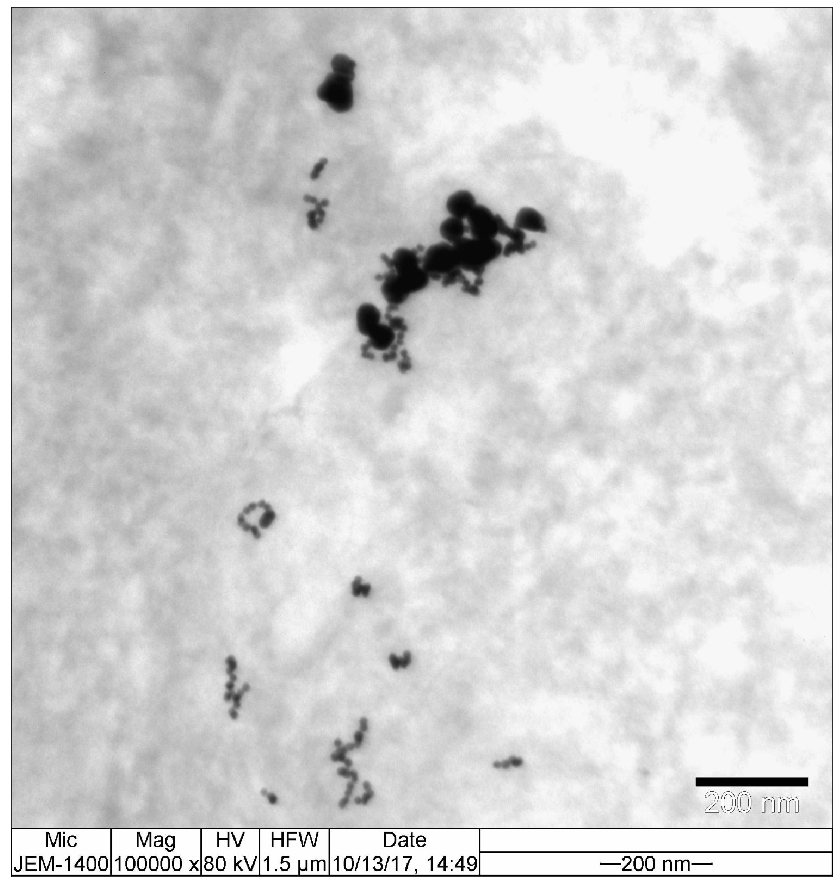

In [10]:
show_image(gray_tem_image)
print("Image Size: ", gray_tem_image.shape)

# Remove the text from the image

In [11]:
gray_tem_image = gray_tem_image[0:1500, 0:1500]
gray_tem_image[1400:1500, 1200:1500] = 255
show_image(gray_tem_image)

In [12]:
show_image(gray_tem_image)

In [13]:
plot_histogram(gray_tem_image)

# Increase sharpness of the image

In [14]:
f = np.fft.fft2(gray_tem_image)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
plt.imshow(magnitude_spectrum, cmap="gray")
fig = plt.gcf()
fig.set_size_inches(8,8)

The spectrum shows us that most energy is in the center and there is a second ring with a lot less energy around the center. We would like to make corners more visible, so we need to make higher frequencies stronger. However, as the higher frequencies get stronger, we start to get rings around our objects; which would make detection very difficult. So we need to amplify some of the higher frequencies, but not all.

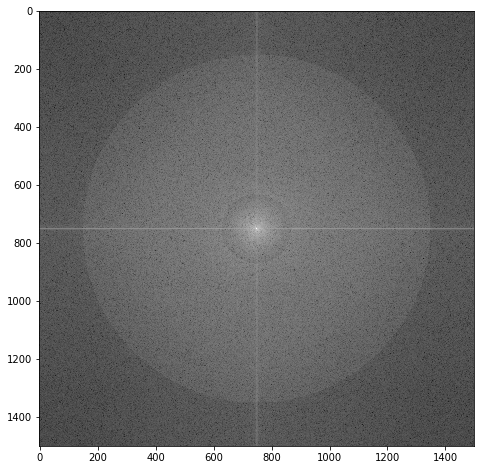

In [15]:
mask = np.ones(fshift.shape, np.uint8)
radius = 60
for i in range(0, fshift.shape[0]-1):
    for j in range(0,  fshift.shape[1]-1):
        if (math.sqrt((fshift.shape[0]/2 - i)**2 + (fshift.shape[1]/2 - j)**2) > 10* radius):
            mask[i,j] = 1
            continue
        if (math.sqrt((fshift.shape[0]/2 - i)**2 + (fshift.shape[1]/2 - j)**2) >  2 * radius):
            mask[i,j] = 2
            continue
        if (math.sqrt((fshift.shape[0]/2 - i)**2 + (fshift.shape[1]/2 - j)**2) > radius):
            mask[i,j] = 1.5
magnitude_spectrum = 20*np.log(np.abs(fshift * mask))
plt.imshow(magnitude_spectrum, cmap="gray")
fig = plt.gcf()
fig.set_size_inches(8,8)


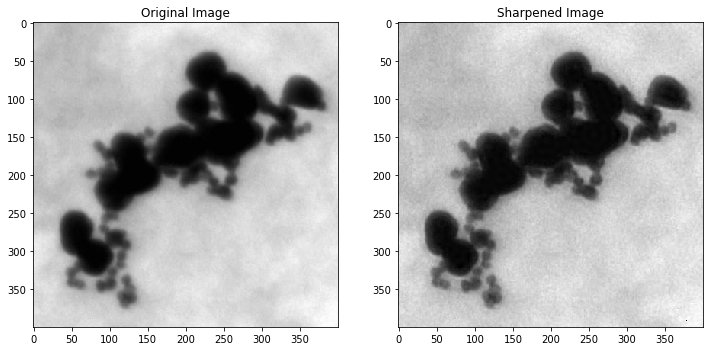

In [16]:
gray_tem_image_fft = np.absolute(np.fft.ifft2(fshift * mask))
gray_tem_image_fft[gray_tem_image_fft>255] = 0
gray_tem_image_fft = gray_tem_image_fft.astype(np.uint8)
# Clear the corner text area again
gray_tem_image_fft[1400:1500, 1200:1500] = 255


plt.subplot(1, 2, 1), plt.imshow(gray_tem_image[300:700, 600:1000], cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2), plt.imshow(gray_tem_image_fft[300:700, 600:1000], cmap='gray')
plt.title('Sharpened Image')
fig = plt.gcf()
fig.set_size_inches(12,10)

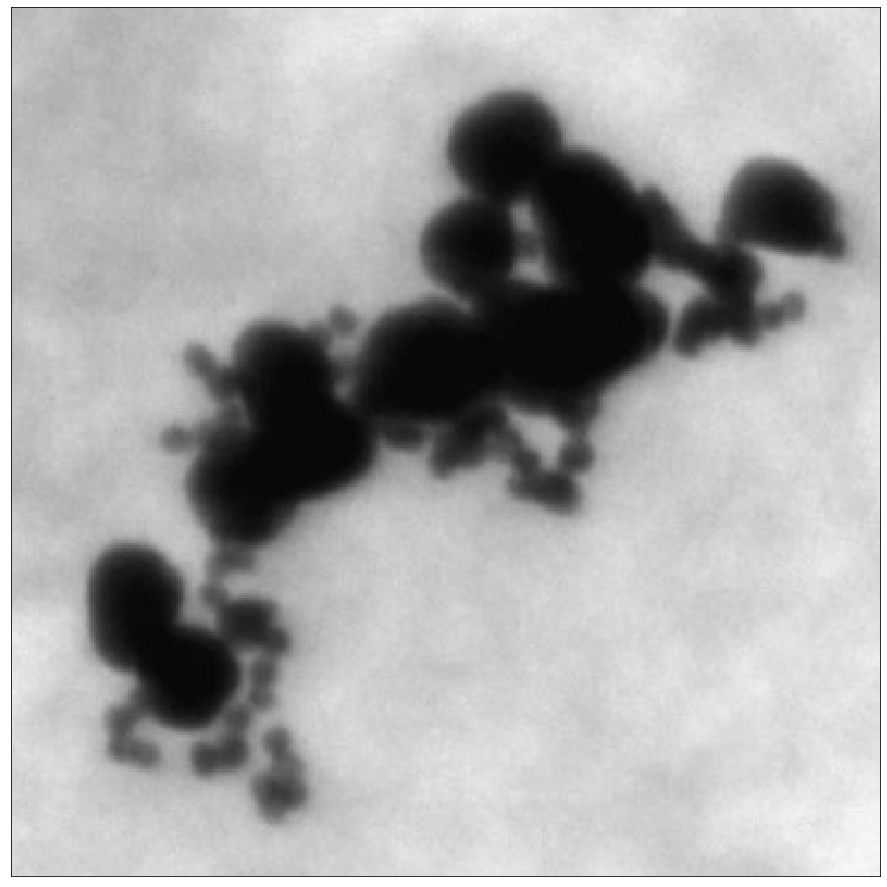

In [17]:
show_image(gray_tem_image[300:700, 600:1000])

In [18]:
show_image(gray_tem_image_fft[300:700, 600:1000])

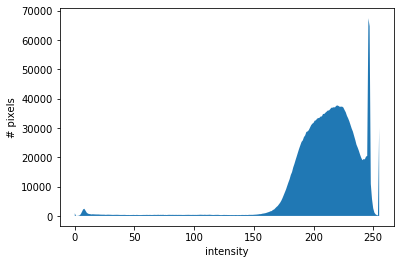

In [19]:
plot_histogram(gray_tem_image_fft)

# Invert the Image & Remove background

Majority of the pixels have values above 150. However the pixels we are interested in are the ones that have values close to zero. In other words, we are interested in the black/dark gray areas. So we need to clear the background and get rid of the bright pixels first.

If we set all the pixels larger than 150 to 255 and invert the image, we can get rid of the background.

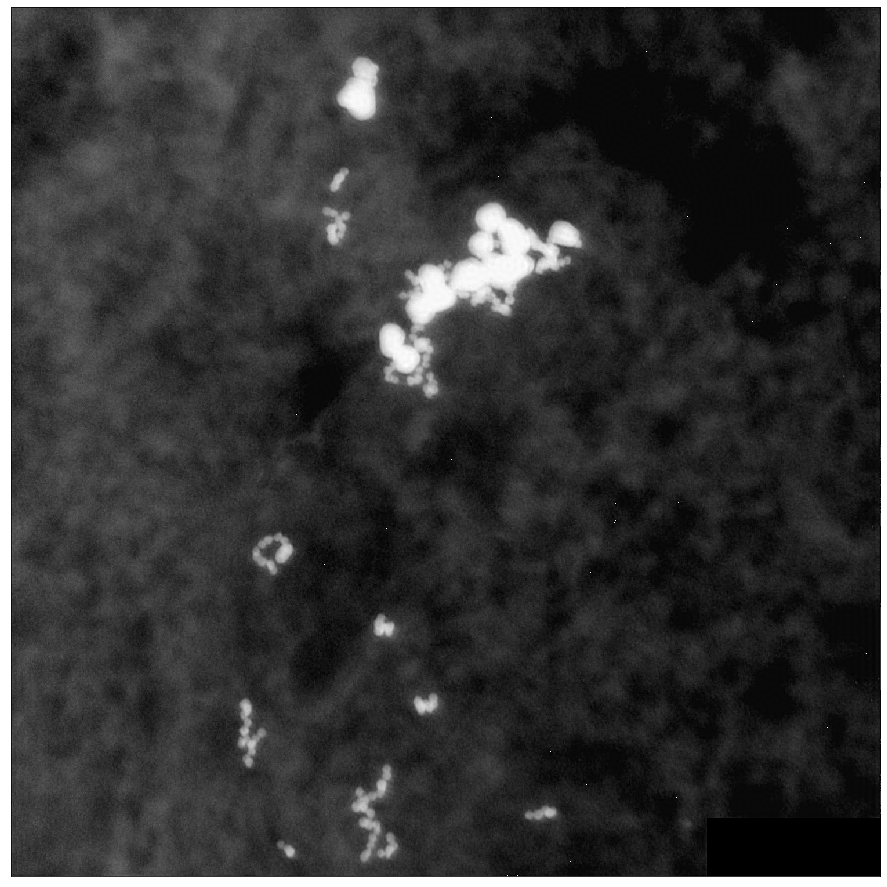

In [20]:
tem_image_invert = ~gray_tem_image_fft.copy()
show_image(tem_image_invert)


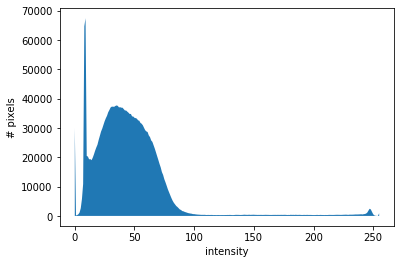

In [21]:
plot_histogram(tem_image_invert)

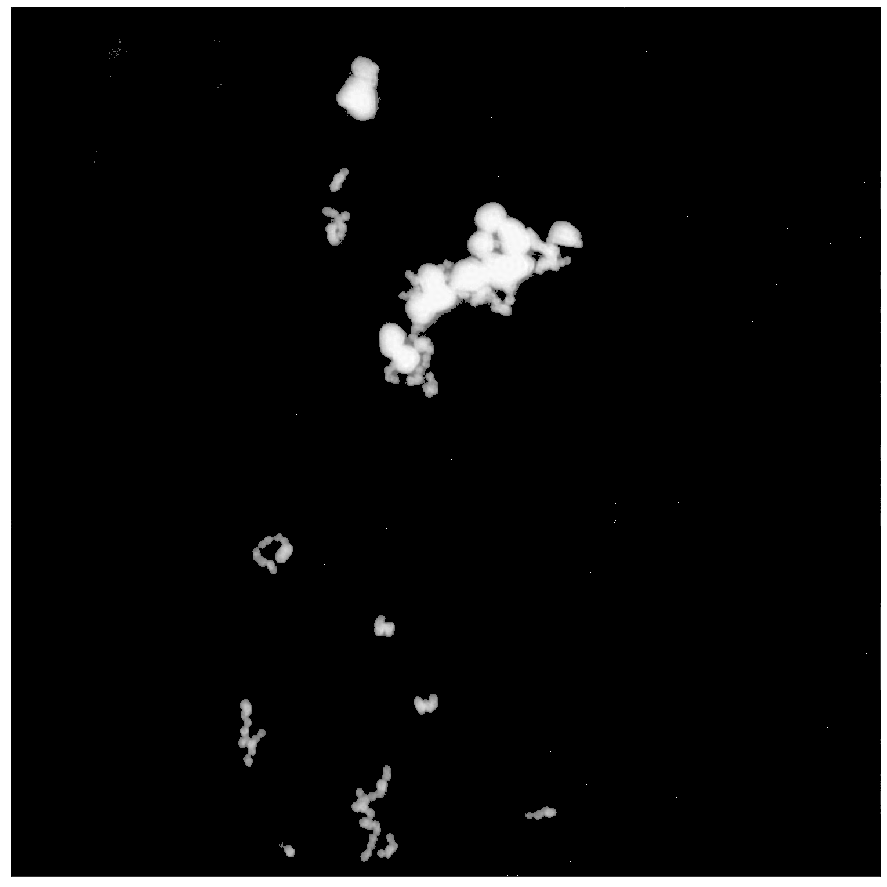

In [22]:
tem_image = gray_tem_image_fft.copy()
tem_image[tem_image > 150] = 255
tem_image = ~tem_image
show_image(tem_image)

This looks like a success. However if we look closely, we can see that we have lost details and gradients around the edges. Also the number we have picked is arbitrary; and changing it causes the image to change, sometimes considerably. For example if we pick 140 instead of 150, the dark gray background pixels on the left top would dissappear; but so does some of the light gray areas that we are interested in. If we pick 160 instead, then we get more gradients; but also more of the background bleeds in. So we need a more reliable method.

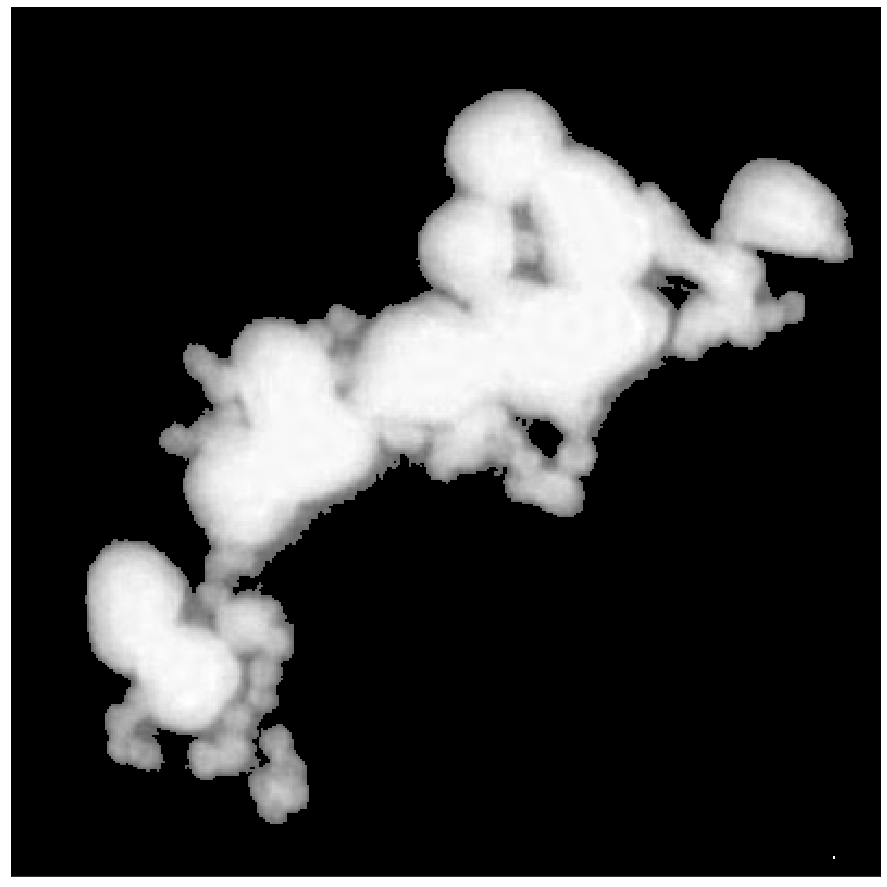

In [23]:
show_image(tem_image[300:700, 600:1000])

IT DID NOT WORK! WE NEED SOMETHING ELSE

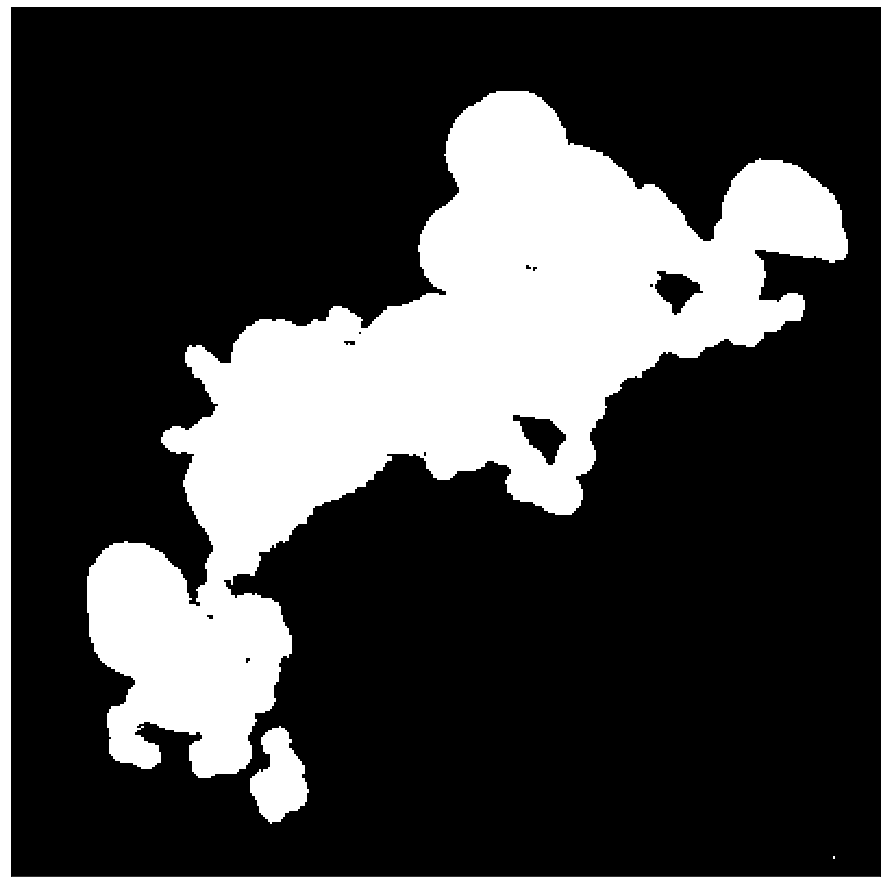

In [24]:
otsu_theshold_values = filters.threshold_otsu(gray_tem_image_fft)
tem_image_otsu = img_as_ubyte(gray_tem_image_fft < otsu_theshold_values)

show_image(tem_image_otsu[300:700, 600:1000])

Since this is a thresholded image, values are either 255 or 0. Since we are interested in different gray levels, this image, as is, is not useful. However we can use it as a mask to isolate the parts of the image that we are interested in. But before doing that, we should make sure that there are no holes in our mask. It would also make sense to widen our mask a little bit to capture more near by pixels.

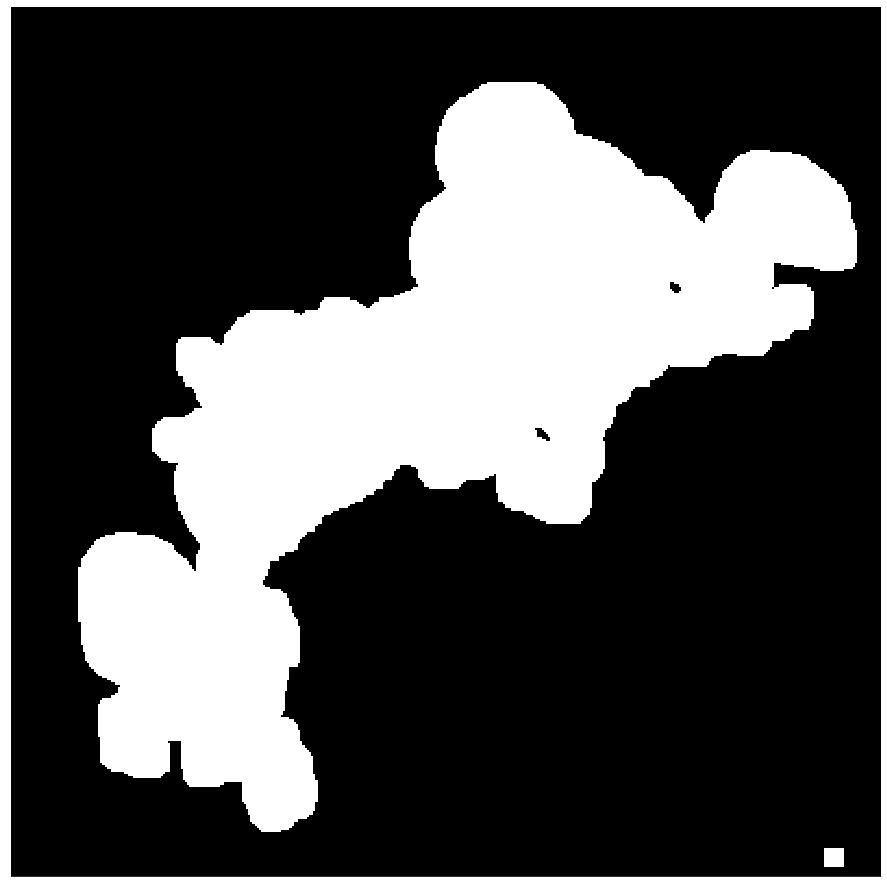

In [25]:
dilated_mask = cv2.dilate(tem_image_otsu, None, iterations=4)
show_image(dilated_mask[300:700, 600:1000])

Now we AND our mask with our original image to get rid of the background.


In [26]:
tem_image = dilated_mask & ~gray_tem_image_fft

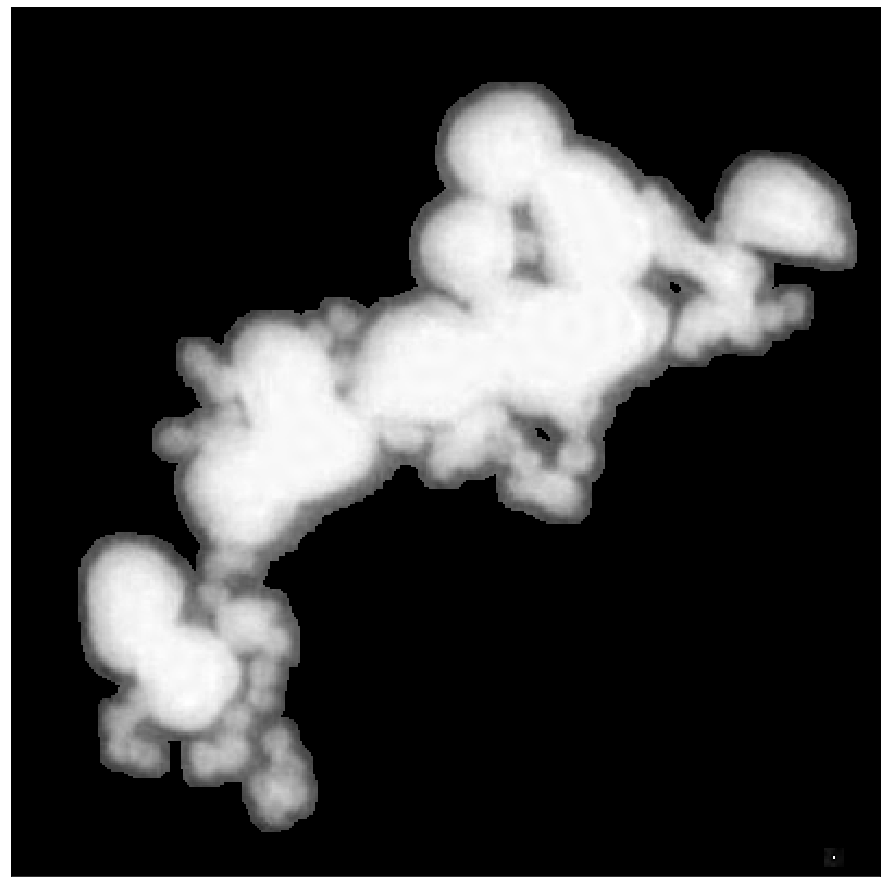

In [27]:
show_image(tem_image[300:700, 600:1000])

This looks better; there are no rugged edges and we have captured all the details we need. Now we need to seperate our particles. However image is too blurry and does not have strong edges. We need to make edges more pronounced.

# Filters

In [28]:
edge_roberts = img_as_ubyte(filters.roberts(img_as_float(tem_image)))
edge_sobel = img_as_ubyte(filters.sobel(img_as_float(tem_image)))
edge_prewitt = img_as_ubyte(filters.prewitt(img_as_float(tem_image)))

laplace = np.array((
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]), dtype="int")
    
edge_laplace = cv2.filter2D(tem_image, -1, laplace)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                         figsize=(12, 10))
ax = axes.ravel()

ax[0].imshow(edge_roberts[300:700, 600:1000], cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel[300:700, 600:1000], cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_laplace[300:700, 600:1000], cmap=plt.cm.gray)
ax[2].set_title('Laplace Edge Detection')

ax[3].imshow(edge_prewitt[300:700, 600:1000], cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.tight_layout()
plt.show()

C:\Users\deniz\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Unfortunately all these filters smooth out the edges between the particles and edge detectors fail to work. The boundaries between objects are not clear enough and there is not enough contrast. 

# Increase the contrast

In [29]:
plot_histogram(tem_image)

Mojority of the pixels we have is the black background; so we should ignore the black (0).

In [30]:
tem_image[tem_image < 50] = 0
plot_histogram(tem_image[tem_image > 0])

We have a somewhat flat distribution with a peak around 245. A further flattened histogram might give us more clear boundaries.

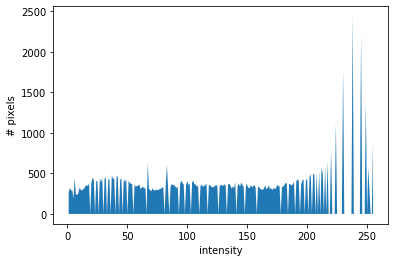

In [31]:
equalized_tem_image = tem_image.copy()
equalized_tem_image_values = img_as_ubyte(exposure.equalize_hist(equalized_tem_image[equalized_tem_image >0]))
equalized_tem_image[equalized_tem_image >0] = equalized_tem_image_values
plot_histogram(equalized_tem_image[equalized_tem_image > 0])

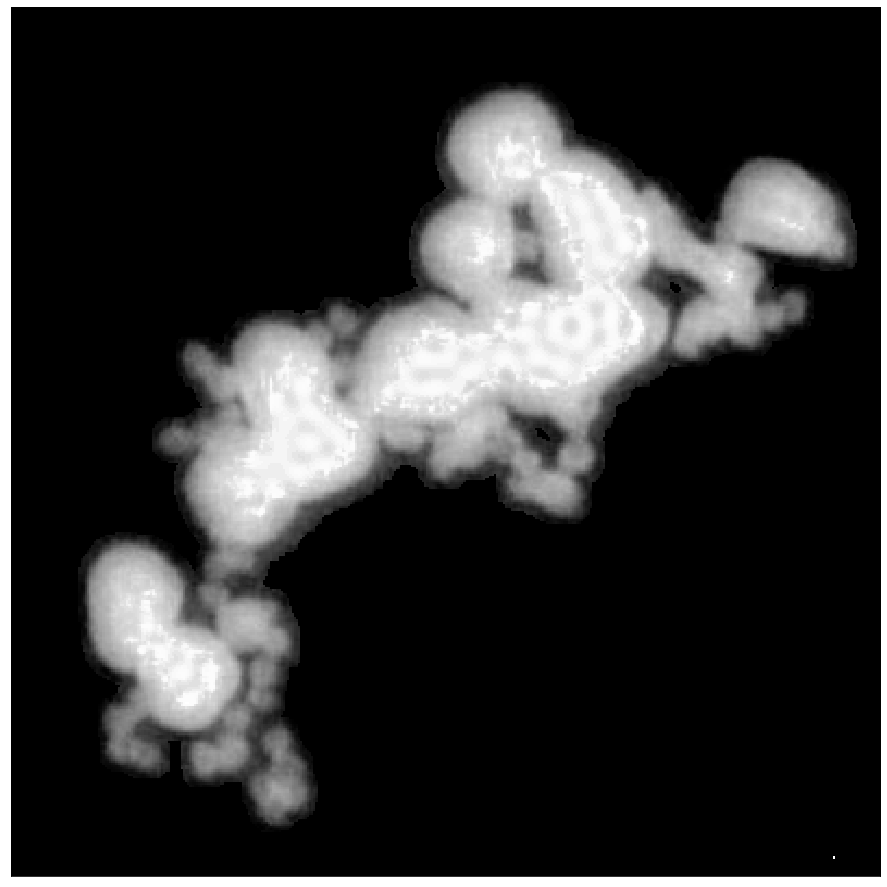

In [32]:
show_image(equalized_tem_image[300:700, 600:1000])

This is ok. Can we do better? Let's try an adaptive approach.

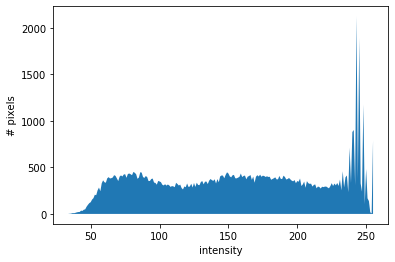

In [33]:
equalized_adaptive_tem_image = tem_image.copy()
equalized_adaptive_tem_image = \
    img_as_ubyte(exposure.equalize_adapthist(equalized_adaptive_tem_image, clip_limit=0.01))
plot_histogram(equalized_adaptive_tem_image[equalized_adaptive_tem_image > 10])

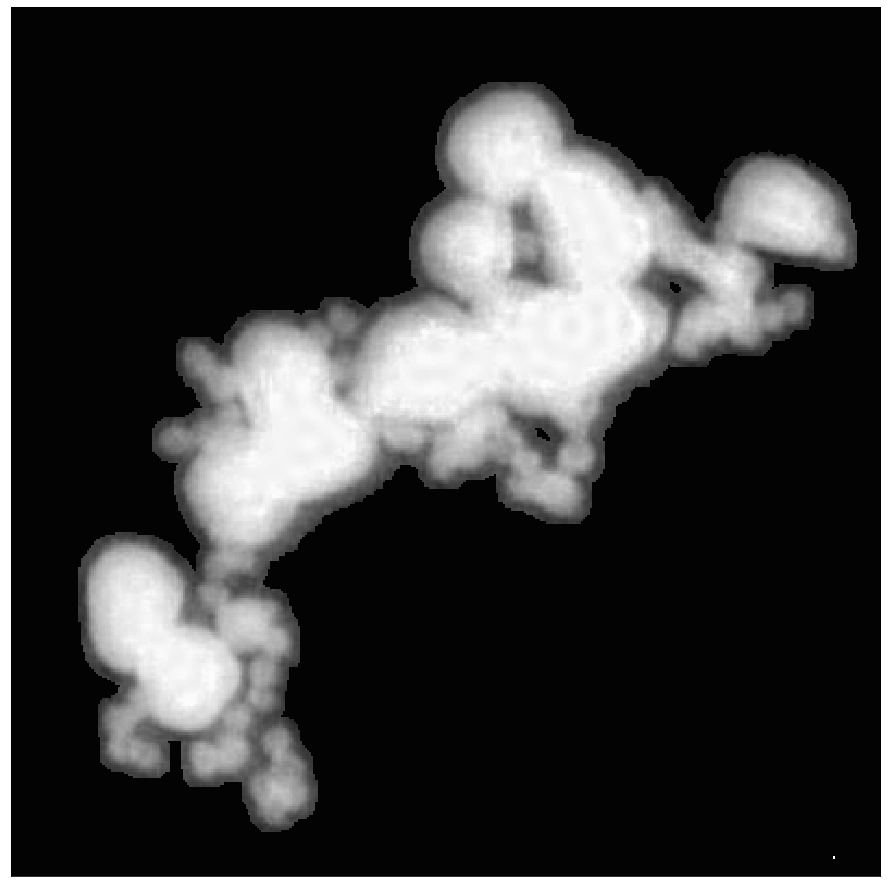

In [34]:
show_image(equalized_adaptive_tem_image[300:700, 600:1000])

How about if we just stretch the values?

In [35]:
rescaled_tem_image = tem_image.copy()
rescaled_tem_image = exposure.rescale_intensity(rescaled_tem_image, (50, 245), (0, 255))
plot_histogram(rescaled_tem_image[rescaled_tem_image > 0])

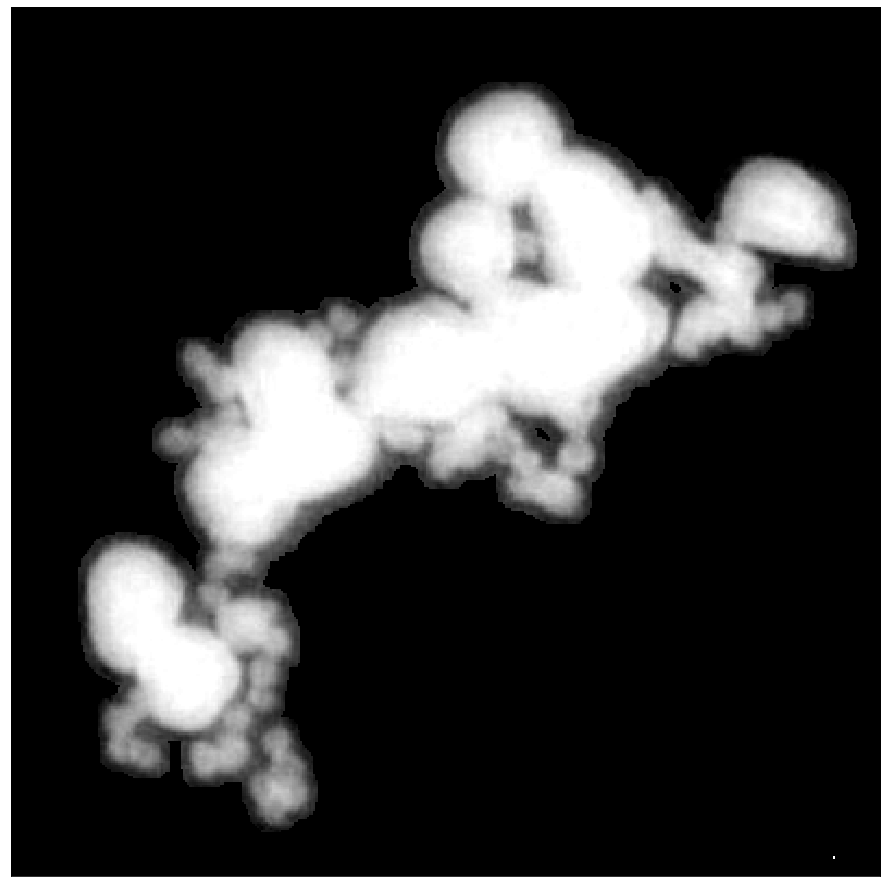

In [36]:
show_image(rescaled_tem_image[300:700, 600:1000])

Of the three approaches equalized_tem_image (the first one) has the most pronounced objects. However it also has a problem. The main bodies are no longer pure white, which might cause issues during segmentation. So we should increase the brightness. However we should not cause the gray gaps to get brighter as well. So we need to increase brightness selectively.

In [37]:
def adjust_s_gamma(image, gamma=0.3, gamma2=0.3, midpoint=128, midpoint_y=127, draw_=False):
    invGamma = 1.0 /  gamma
    invGamma2 = 1.0 / gamma2
    table1 = np.array([((i / (midpoint -1)) ** invGamma) * midpoint_y
        for i in np.arange(0, midpoint)]).astype("uint8")
    table2 =  np.flip(255 - np.array([((i / (255 - midpoint + 1)) ** invGamma2) * (256 - midpoint_y)
        for i in np.arange(0,256-midpoint)]).astype("uint8"))
    table = np.concatenate((table1, table2)).astype("uint8")
    
    if draw_ is True:
        plt.plot(table)
    return cv2.LUT(image, table)

In [38]:
brighter_tem_image = adjust_s_gamma(equalized_adaptive_tem_image, 0.15, 0.15, 180, 180,  draw_=True)

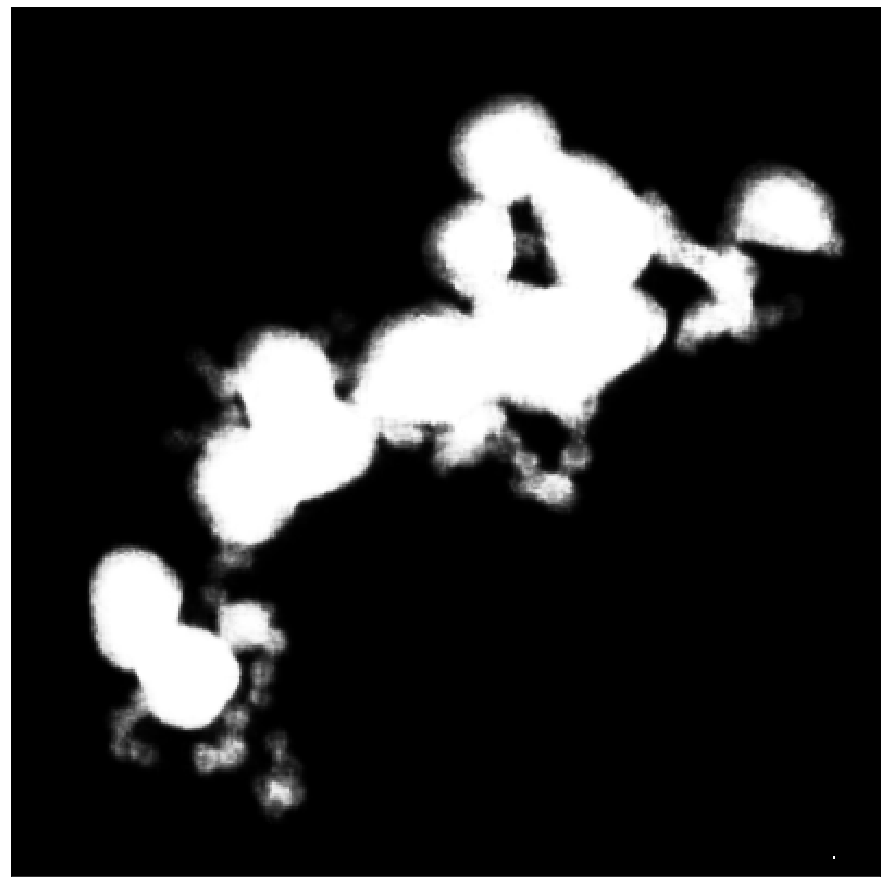

In [39]:
show_image(brighter_tem_image[300:700, 600:1000])

# Threshold the image

In [40]:
plot_histogram(brighter_tem_image[brighter_tem_image > 0])

Now we need to threshold the image to be able to segment it. However as can be seen from the histogram, there is not any specific level that we can use. Both smaller particles and boundaries of large particles have gray values; and it is difficult to distinguish between them.

So we use an adaptive threshold once again. This time we use an algorithm called Sauvola, which allows us to set the window size. It uses the mean and standard deviation of the local neighbor pixels; so it can help us isolate main bodies.

In [41]:
def otsu_sauvola(image_, window_size_=5, k_=0.1):
    image = img_as_ubyte(image_)
    binary_image = image > threshold_sauvola(image, window_size_, k_)
    cvim =  img_as_ubyte(binary_image)
    cvim[cvim == 1] = 255
    return cvim

In [42]:
thresholded_tem_image = otsu_sauvola(brighter_tem_image, 21, 0.05)

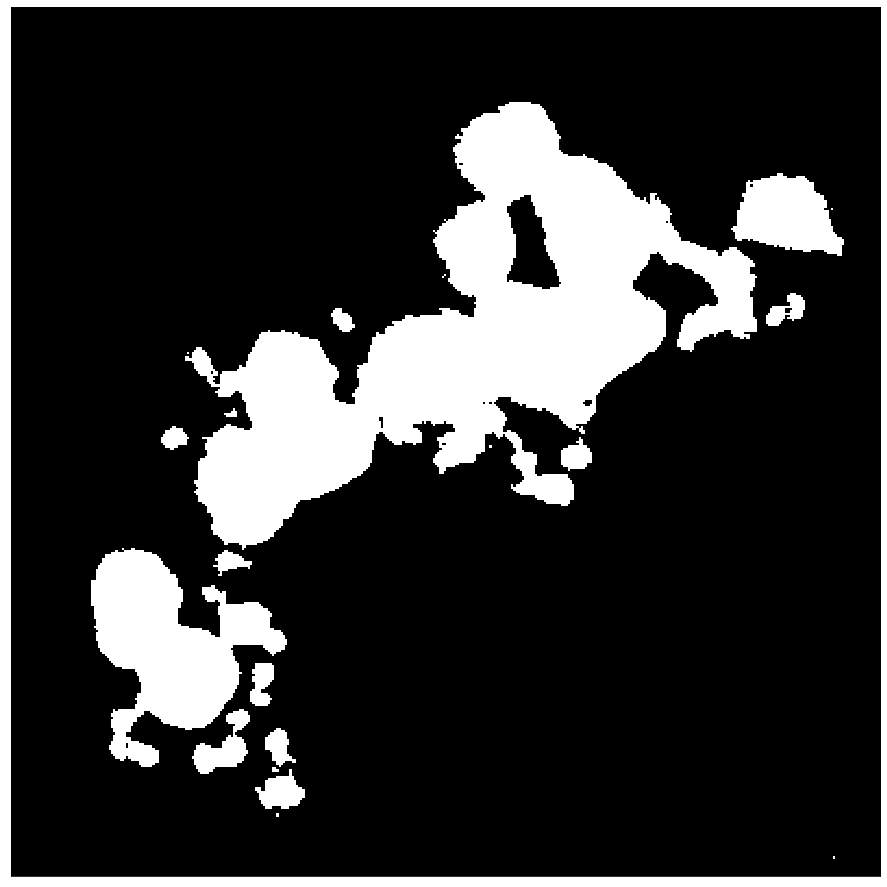

In [43]:
show_image(thresholded_tem_image[300:700, 600:1000])

This actually looks like an image we can work with. However there are small holes in some of the bodies. So we need to do morph close operation for that.

In [44]:
image_ = thresholded_tem_image.copy()
for i in range(0,2):
    closed = cv2.erode(image_, None)
    image_ = cv2.dilate(closed, None)
closed_threshold_image = image_.copy()
show_image(closed_threshold_image[300:700, 600:1000])

# Segmentation

Now that we have our image ready, we need to segment it. For this we will use an algorithm called watershed and distance transform. Distance transform calculates how far a pixel is away from the background. So as we move deeper into an object, distance increases and it would maximize at the center of it. So we will mark these local maximums as our objects and apply the watershed algorithm. In the watershed algorithm we follow the decent of the distances from their maximum values to local minimum values; just like water would flow down from top to a ridge. When watershed algorithm finds a plateau, it would mean that we have reached the boundaries of our object.

In [45]:
distance = ndi.distance_transform_edt(closed_threshold_image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((13, 13)),
                            labels=closed_threshold_image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=closed_threshold_image)
segmented_image = label2rgb(labels * 2, image=tem_image, bg_label=0) 

rects = []
for region in regionprops(labels):
    minr, minc, maxr, maxc = region.bbox
    rects.append([minc, minr, maxc - minc, maxr - minr])

rectz = []
for rect in rects:
    rectn = [rect[0], rect[1], rect[0] + rect[2], rect[1] + rect[3]]
    rectz.append(rectn)
segmented_image_rects = draw_rectangles(img_as_ubyte(segmented_image), rectz)
    

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40, 40))
ax = axes.ravel()    
ax[0].imshow(closed_threshold_image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40, 40))
ax = axes.ravel() 
ax[0].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[0].set_title('Separated objects')
ax[1].imshow(segmented_image_rects)
ax[1].set_title('Rectangles')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [47]:
show_image(segmented_image_rects[300:700, 600:1000])